## 1 Importy i pobranie danych

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Reprezentacja graficzna
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


# Uczenie płytkie
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import  metrics


# StandardScaler 
from sklearn.preprocessing import StandardScaler

# inne
from scipy.stats.distributions import uniform, randint
import math

# Uczenie głębokie
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import layers
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
data.head(5)



*   Data - The date of observation
*   Location - The common name of the location of the weather station
*   Rainfall - The amount of rainfall recorded for the day in mm
*   Evaporation - The so-called Class A pan evaporation (mm) in the 24 hours to 9am
*   Sunshine - The number of hours of bright sunshine in the day.
*   WindGustDir - The direction of the strongest wind gust in the 24 hours to midnight
*   WindGustSpeed - The speed (km/h) of the strongest wind gust in the 24 hours to midnight
*   WindDir9am - Direction of the wind at 9am
*   WindDir3pm - Direction of the wind at 3pm
*   WindSpeed9am- Wind speed (km/hr) averaged over 10 minutes prior to 9am
*   WindSpeed3pm -Wind speed (km/hr) averaged over 10 minutes prior to 3pm
*   Humidity9am - Humidity (percent) at 9am
*   Humidity3pm - Humidity (percent) at 3pm
*   Pressure9am - Atmospheric pressure (hpa) reduced to mean sea level at 9am
*   Pressure3pm - Atmospheric pressure (hpa) reduced to mean sea level at 3pm
*   Cloud9am - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many
*   Cloud3pm - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
*   Temp9am - Temperature (degrees C) at 9am
*   Temp3pm - Temperature (degrees C) at 3pm
*   RainToday - Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
*   RainTomorrow
The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".


## 2 Przygotowanie danych
Na początku sprawdźmy ile i gdzie są wartości nullowe



In [ ]:
# ile i gdzie wartości nullowe
data.isnull().sum()

In [ ]:
len(data)

Prawie 6% wartości WindDir9am jest nullowych i około 1.5 % WindDir3pm oraz Location. Trzeba będzie czymś je uzupełnić. W pozostałych kolumnach brakuących wartości jest < 1%

In [ ]:
data.info()

In [ ]:
data.describe()

Na początku zamieńmy wszystkie wartości yes, no na 1 i 0

In [ ]:
data = data.replace(["Yes", "No"], [1, 0], regex = True)
data.head()

Sprawdźmy korelacje pomiędzy kolumnami aby nie było powielania informacji



In [ ]:
corr = data.corr()
corr

In [ ]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [ ]:
sns.pairplot( data=data, vars=('Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation', 'Sunshine'), hue='RainTomorrow' )

Zdefiniujmy funkcje która będzie dziliła nam dane na biny a nastepnie dla każdego bina wyliczała prawdopodobieństwo opadu

In [ ]:
def check_probability(input_name, size=10):
  new_name = input_name + " rounded values"
  data[new_name] = data[input_name].apply(lambda x: math.ceil(x))

  g = sns.factorplot(x=new_name,y="RainTomorrow",data=data, kind="bar", size = size)
  g.despine(left=True)
  g = g.set_ylabels("rain probability")

  data.drop(labels = [new_name], axis = 1, inplace = True)

### 2.1. Date
Spróbujmy wyciągnąć z daty miesiąc, po czym zamienić go na dane kategoryczne

In [ ]:
data['Month'] = pd.DatetimeIndex(data['Date']).month.astype(str)

In [ ]:
data.head(5)

In [ ]:
data.drop(labels = ["Date"], axis = 1, inplace = True)

In [ ]:
data.columns

Sprawdźmy czy miesiąć ma wpływ na to czy następnego dnia będzie padać

In [ ]:
g = sns.factorplot(x="Month",y="RainTomorrow",data=data, kind="bar", size = 6)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Jak widać w miesiącach jesiennych możemy się liczyć z mniejszym prawdopodobieństwem opadu

### 2.2. Location

In [ ]:
data['Location'].value_counts()

In [ ]:
g = sns.factorplot(x="Location",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Jak widać największe szanse na opad są w CoffsHarbour oraz WitchIsland

### 2.3. Rainfall i RainToday
Pomiędzy Rainfall i RainToday jest zależność polegająca na tym, że jeśli w Rainfall jest wartość większa od 1 to RainToday jest True. W przeciwnym wypadku False. Także aby nie powielać informacji usuńmy kolumne RainToday

In [ ]:
data.drop(labels = ["RainToday"], axis = 1, inplace = True)

Jak możemy dostrzec Rainfall przyjmuje jakąś wartość kiedy w RainToday mamy 1, więć aby nie powielac informacji usuiemy kolumne RainToday i uzupełnijmy Rainfall średnią

In [ ]:
g = sns.FacetGrid(data, col='RainTomorrow')
g = g.map(sns.distplot, "Rainfall")

In [ ]:
data['Rainfall'].fillna(data['Rainfall'].mean(), inplace=True)

In [ ]:
data['Rainfall'].isnull().sum()

### 2.4. Evaporation 

In [ ]:
data['Evaporation'].isnull().sum()

In [ ]:
check_probability("Evaporation")

Można powiedzieć, że im większe odparowanie tym mniejsza szansa na deszcz

### 2.5. Sunshine

In [ ]:
out = pd.cut(data["Sunshine"], bins=[x for x in range (0, 20)], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(20,6))
plt.show()

In [ ]:
check_probability("Sunshine")

Jak widać powyżej im więcej słonecznych godzin tym mniejsza szansa na deszcz jutro

In [ ]:
data['Sunshine'].isnull().sum()

### 2.6. WindDir
Będziemy musieli uzupełnić brakujące wartości poprzez danie w miejsce nulli najczęściej występującej wartości

In [ ]:
data['WindDir9am'].isnull().sum()

In [ ]:
data['WindDir9am'].value_counts()

In [ ]:
#data['WindDir9am'] = data['WindDir9am'].fillna(data['WindDir9am'].mode().iloc[0])

In [ ]:
data['WindDir9am'].isnull().sum()

In [ ]:
data['WindDir9am'].value_counts()

In [ ]:
#data = pd.get_dummies(data, columns = ['WindDir9am'])

In [ ]:
g = sns.factorplot(x="WindDir9am",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

Największe szanse na deszcz są przy wietrze wiejącym wkierunku SSW (południowo zachodnim, ale bardziej skierowanemu na południe). Za chwilę zobaczymy czy podobne obserwacje będą przy wietsze o godzinie 15.00

In [ ]:
data['WindDir3pm'].isnull().sum()

In [ ]:
data['WindDir3pm'].value_counts()

In [ ]:
#data['WindDir3pm'] = data['WindDir3pm'].fillna(data['WindDir3pm'].mode().iloc[0])

In [ ]:
data['WindDir3pm'].isnull().sum()

In [ ]:
#data = pd.get_dummies(data, columns = ['WindDir3pm'])

In [ ]:
g = sns.factorplot(x="WindDir3pm",y="RainTomorrow",data=data, kind="bar", size = 10)
g.despine(left=True)
g = g.set_ylabels("rain probability")

### 2.7. Unnamed: 0
Wyrzućmy tą nic nie wnoszącą kolumne

In [ ]:
data.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [ ]:
data.columns

### 2.8. WindSpeed
Zastąpmy brakujące wartości wartościami średnimi

In [ ]:
data['WindSpeed9am'].fillna(data['WindSpeed9am'].mean(), inplace=True)
data['WindSpeed3pm'].fillna(data['WindSpeed3pm'].mean(), inplace=True)

In [ ]:
check_probability("WindSpeed9am")

In [ ]:
check_probability("WindSpeed3pm")

Humidity9am       14
Humidity3pm       13
Pressure9am       23
Pressure3pm       16
Cloud9am           0
Cloud3pm           0

### 2.9. Humidity

In [ ]:
data['Humidity3pm'].fillna(data['Humidity3pm'].mean(), inplace=True)
data['Humidity9am'].fillna(data['Humidity9am'].mean(), inplace=True)

In [ ]:
check_probability("Humidity9am", 14)

In [ ]:
check_probability("Humidity3pm", 15)

Również można dostrzec zależność, że im większa wilgotność tym większa szansa na opad

### 2.10. Pressure

In [ ]:
data['Pressure3pm'].fillna(data['Pressure3pm'].mean(), inplace=True) 
data['Pressure9am'].fillna(data['Pressure9am'].mean(), inplace=True)

In [ ]:
check_probability('Pressure9am', 15)

In [ ]:
check_probability('Pressure3pm', 20)

### 2.11. Cloud

In [ ]:
check_probability("Cloud9am")

In [ ]:
check_probability("Cloud3pm")

W obu przypadkach możemy dojśc do wniosku, że im większa część nieba jest przysłonięta chmurami to tym większe prawdopodobieństwo opadów

## 3 Pipeline'y

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline dla numerycznych



In [ ]:
numerical_fields = ["Evaporation", "Rainfall", "Sunshine", "WindGustSpeed", 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numerical_fields)),
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])


Pipeline dla kategorycznych

In [ ]:
catbin = ["Location","WindGustDir" ,"WindDir9am", "WindDir3pm", "Month"]

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(catbin)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [ ]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

## 4 Podział danych na train i test

In [ ]:
y = data["RainTomorrow"]
X = data.drop("RainTomorrow", axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
num_pipeline.fit_transform(X_train)

In [ ]:
cat_pipeline.fit_transform(X_train)

In [ ]:
seed=123
kfold = StratifiedKFold(n_splits=10)

# 5 Uczenie modeli

## 5.1 Uczenie płytkie

### 5.1.1 Decision Tree

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('scaler',  StandardScaler()),
    ('classifier', DecisionTreeClassifier())
    ])

dt_param_grid = {
    'classifier__max_depth': range(2, 10),
    'classifier__max_features': range(2, 14),
    }

gsDT = GridSearchCV(pipe, dt_param_grid, cv=kfold, verbose=10)
gsDT.fit(X_train,y_train)
DT_best = gsDT.best_estimator_

### 5.1.2 Random Forest Classifier

In [ ]:
# Random Forest Classifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier())])



rf_param_grid = { 
    'classifier__n_estimators': [100, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [3,5,7,9],
    'classifier__criterion': ['gini']
}

gsRFC = GridSearchCV(pipe, rf_param_grid, cv=kfold, verbose=10)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_

print(gsRFC.best_score_)

### 5.1.3 Gradient Boosting

In [ ]:
# Gradient boosting tunning

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', GradientBoostingClassifier())])


gb_param_grid = {'classifier__loss' : ["deviance"],
              'classifier__n_estimators' : [100,200],
              'classifier__learning_rate': [0.05, 0.1],
              'classifier__max_depth': [4, 8, 12],
              'classifier__max_features': [0.5, 0.3, 0.1] 
              }

gsGBC = GridSearchCV(pipe, gb_param_grid, cv=kfold, verbose=10)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

### 5.1.4 Logistic Regression

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', LogisticRegression())])

LR_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


gsLR = GridSearchCV(pipe ,param_grid = LR_param_grid, cv=kfold, verbose = 10)

gsLR.fit(X_train,y_train)

LR_best = gsLR.best_estimator_

gsLR.best_score_

### 5.1.5 XGBoost

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', XGBClassifier())])

param_distribution = {
    'classifier__max_depth': randint(3, 20),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__n_estimators': randint(50, 600),
    'classifier__gamma': uniform(0,2),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': randint(1, 11)
}


gsXGB = RandomizedSearchCV(pipe, param_distribution, n_iter=32, verbose=10 )

gsXGB.fit(X_train, y_train)
XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

### 5.1.6 SVC linear

In [ ]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel="linear"))])

param_grid = {
          
            'classifier__gamma': [0.001, 0.1, 1, ],
            'classifier__C': [0.001, 0.1, 1,],
            'classifier__probability': [True]
}

gsSVC_linear = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)

gsSVC_linear.fit(X_train, y_train)

gsSVC_linear_best = gsSVC_linear.best_estimator_

# Best score
gsSVC_linear.best_score_

### 5.1.7 Ada Boost

In [ ]:
DTC = DecisionTreeClassifier()

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', AdaBoostClassifier(DTC, random_state=7))])

ada_param_grid = {"classifier__base_estimator__criterion" : ["gini", "entropy"],
              "classifier__base_estimator__splitter" :   ["best", "random"],
              "classifier__algorithm" : ["SAMME","SAMME.R"],
              "classifier__n_estimators" :[1,2],
              "classifier__learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsAda = GridSearchCV(pipe ,param_grid = ada_param_grid, cv=kfold, verbose = 10)

gsAda.fit(X_train, y_train)

ada_best = gsAda.best_estimator_

### 5.1.9 Voting classifier (hard)

In [ ]:
# Hard voting 

hard_voting_class = VotingClassifier(estimators=[ ('DT', DT_best),('RFC', RFC_best),
('GBC',GBC_best), ('XGB', XGB_best)], voting='hard')

hard_voting = hard_voting_class.fit(X_train, y_train)

### 5.1.10 Voitng classifier (soft)

In [ ]:
# Soft voting


soft_voting_class = VotingClassifier(estimators=[ ('DT', DT_best),('XGBoost', RFC_best),
('GBC',GBC_best), ('XGB', XGB_best)], voting='soft')

soft_voting = soft_voting_class.fit(X_train, y_train)

### 5.1.11 Porównianie modeli płytkich

In [ ]:
models = []
models.append(('DecisionTree', gsDT.best_estimator_))
models.append(('RandomForest', gsRFC.best_estimator_))
models.append(('GradientBoosting', gsGBC.best_estimator_))
models.append(('XGBoost', gsXGB.best_estimator_))
models.append(('LogisticRegression', gsLR.best_estimator_))
models.append(('SVC_linear', gsSVC_linear.best_estimator_))
models.append(('Ada Boost', gsAda.best_estimator_))
models.append(('Hard voting', hard_voting))
models.append(('Soft voting', soft_voting))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

In [ ]:
models2 = []
models2.append(('DecisionTree', gsDT.best_estimator_))
models2.append(('RandomForest', gsRFC.best_estimator_))
models2.append(('GradientBoosting', gsGBC.best_estimator_))
models2.append(('XGBoost', gsXGB.best_estimator_))
models2.append(('LogisticRegression', gsLR.best_estimator_))
models.append(('SVC_linear', gsSVC_linear.best_estimator_))
models2.append(('Ada Boost', gsAda.best_estimator_))
#models2.append(('Hard voting', hard_voting))
models2.append(('Soft voting', soft_voting))


for name, model in models2:
    print(name)
    print("roc_score: {}".format(roc_auc_score(y_test, model.predict(X_test))))
   
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
 
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = '%s AUC = %0.10f' % (name, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([-0.1, 1.1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

plt.rcParams["figure.figsize"] = (25,12)
plt.show()

In [ ]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Decision tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'Logistic Regression','SVC Linear', 'Ada Boost','Hard Voting', 'Soft Voting'])
df

## 5.2 Uczenie głębokie

Najpierw przetwórzmy nasze dane przy pomocy pipelineów

In [ ]:
X_train2 = preprocess_pipeline.transform(X_train)
X_test2 = preprocess_pipeline.transform(X_test)

### 5.2.1 Sieć bez bajerów

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential()
model1.add(layers.Dense(82, input_dim=82, activation='sigmoid'))
model1.add(layers.Dense(41, input_dim=82, activation='sigmoid'))
model1.add(layers.Dense(20, input_dim=82, activation='sigmoid'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history1 = model1.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(25, 12))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.2 Sieć z early stoppingiem

In [ ]:
model2 = keras.models.Sequential()
model2.add(layers.Dense(82, input_dim=82, activation='elu'))
model2.add(layers.Dense(41, input_dim=82, activation='elu'))
model2.add(layers.Dense(20, input_dim=82, activation='elu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
history2 = model2.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test), callbacks=[early_stopping])

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(25, 12))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.3 Sieć z BatchNormalization

In [ ]:
model3 = Sequential()
model3.add(Flatten(input_shape=[82,]))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(300))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(100))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer="sgd",
              metrics=["accuracy"])

history3 = model3.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(25, 12))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.4 Sieć z BatchNormalization i Dropoutem

In [ ]:
model4 = Sequential()
model4.add(Flatten(input_shape=[82,]))
model4.add(BatchNormalization())
model4.add(Activation('elu'))
model4.add(Dropout(0.3))

model4.add(Dense(300))
model4.add(BatchNormalization())
model4.add(Activation('elu'))
model4.add(Dropout(0.3))

model4.add(Dense(100))
model4.add(BatchNormalization())
model4.add(Activation('elu'))
model4.add(Dropout(0.3))

model4.add(Dense(1))
model4.add(Activation('sigmoid'))

model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer="sgd",
              metrics=["accuracy"])

history4 = model4.fit(X_train2, y_train, epochs=100, validation_data=(X_test2, y_test))

In [ ]:
pd.DataFrame(history4.history).plot(figsize=(25, 12))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 5.2.5 Randomized Search

In [85]:
keras.backend.clear_session()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[82,], activation_function='sigmoid'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation_function))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [86]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [87]:
param_distribs = {
    "n_hidden": [2, 3, 4, 5],
    "n_neurons": np.arange(1, 100), 
    "activation_function": ['relu', 'elu', 'sigmoid']
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train2, y_train, epochs=100, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 4ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 1s 4ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6678 - accuracy: 0.2349 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.23

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5178 - accuracy: 0.7661 - val_loss: 0.4732 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4734 - accuracy: 0.7696 - val_loss: 0.4364 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4571 - accuracy: 0.7750 - val_loss: 0.4166 - val_accuracy: 0.7962
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 10.7040 - accuracy: 0.2814 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epo

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.21

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5438 - accuracy: 0.7667 - val_loss: 0.5430 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.7667 - val_loss: 0.5424 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.7667 - val_loss: 0.5424 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5438 - accuracy: 0.7667 - val_loss: 0.5438 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7667 - val_loss: 0.5424 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5439 - accuracy: 0.7667 - val_loss: 0.5429 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.7667 - val_loss: 0.5426 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6227 - accuracy: 0.7651 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5462 - accuracy: 0.7651 - val_loss: 0.5410 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5465 - accuracy: 0.7651 - val_loss: 0.5425 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5460 - accuracy: 0.7651 - val_loss: 0.5401 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7651 - val_loss: 0.5428 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.7651 - val_loss: 0.5475 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5453 - accuracy: 0.7651 - val_loss: 0.5416 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7651 - val_loss: 0.5389 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5468 - accuracy: 0.7632 - val_loss: 0.5231 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5425 - accuracy: 0.7685 - val_loss: 0.5247 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5427 - accuracy: 0.7685 - val_loss: 0.5295 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5429 - accuracy: 0.7685 - val_loss: 0.5321 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5421 - accuracy: 0.7685 - val_loss: 0.5269 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.7685 - val_loss: 0.5216 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5414 - accuracy: 0.7685 - val_loss: 0.5240 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5663 - accuracy: 0.7915 - val_loss: 0.5045 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4797 - accuracy: 0.8069 - val_loss: 0.4798 - val_accuracy: 0.7962
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 5.7158 - accuracy: 0.5450 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.6911 - accuracy: 0.2333 - val_loss: 11.7038 - val_accuracy: 0.2325
Ep

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 2ms/step - loss: 0.8276 - accuracy: 0.7401 - val_loss: 0.5558 - val_accuracy: 0.7738
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5785 - accuracy: 0.7997 - val_loss: 11.5918 - val_accuracy: 0.2325
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 1.3782 - accuracy: 0.7000 - val_loss: 0.4505 - val_accuracy: 0.8213
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8229 - val_loss: 0.4493 - val_accuracy: 0.8263
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8336 - val_loss: 0.4267 - val_accuracy: 0.8275
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.8376 - val_loss: 0.4113 - val_accuracy: 0.8350
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8382 - val_loss: 0.4051 - val_accuracy: 0.8363
Epoch 8/10

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5356 - accuracy: 0.7792 - val_loss: 0.4481 - val_accuracy: 0.8000
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4505 - accuracy: 0.8090 - val_loss: 0.4245 - val_accuracy: 0.8125
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4555 - accuracy: 0.8112 - val_loss: 0.4415 - val_accuracy: 0.8138
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.8214 - val_loss: 0.4144 - val_accuracy: 0.8213
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.8115 - val_loss: 0.6027 - val_accuracy: 0.6913
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.8204 - val_loss: 0.4417 - val_accuracy: 0.8238
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4083 - accuracy: 0.8314 - val_loss: 0.3837 - val_accuracy: 0.8275
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 1.3966 - accuracy: 0.7797 - val_loss: 7.0281 - val_accuracy: 0.4900
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 5.1134 - accuracy: 0.6154 - val_loss: 2.3844 - val_accuracy: 0.8025
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 2.0653 - accuracy: 0.8112 - val_loss: 2.0491 - val_accuracy: 0.8100
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 2.8751 - accuracy: 0.7611 - val_loss: 2.3037 - val_accuracy: 0.7950
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 2.0396 - accuracy: 0.8106 - val_loss: 2.2232 - val_accuracy: 0.8087
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 1.5281 - accuracy: 0.8285 - val_loss: 1.6345 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.9749 - accuracy: 0.8211 - val_loss: 0.6291 - val_accuracy: 0.7850
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 2.8930 - accuracy: 0.7281 - val_loss: 3.5635 - val_accuracy: 0.7563
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 4.5988 - accuracy: 0.6942 - val_loss: 3.5914 - val_accuracy: 0.7650
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6740 - accuracy: 0.7614 - val_loss: 3.6069 - val_accuracy: 0.7650
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.6680 - accuracy: 0.7617 - val_loss: 3.6060 - val_accuracy: 0.7650
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.6619 - accuracy: 0.7621 - val_loss: 3.6071 - val_accuracy: 0.7650
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.4188 - accuracy: 0.7743 - val_loss: 3.2018 - val_accuracy: 0.7912
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 3.9004 - accuracy: 0.7419 - val_loss: 3.7248 - val_accuracy: 0.7550
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 1.3723 - accuracy: 0.7986 - val_loss: 1.9865 - val_accuracy: 0.8225
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 2.8346 - accuracy: 0.7778 - val_loss: 2.8098 - val_accuracy: 0.7738
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 2.7266 - accuracy: 0.7947 - val_loss: 3.1393 - val_accuracy: 0.7900
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 3.2245 - accuracy: 0.7821 - val_loss: 2.8063 - val_accuracy: 0.8025
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 2.6960 - accuracy: 0.7997 - val_loss: 2.1598 - val_accuracy: 0.8363
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 2.7844 - accuracy: 0.7983 - val_loss: 2.9037 - val_accuracy: 0.7975
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 2.7328 - accuracy: 0.8003 - val_loss: 2.3766 - val_accuracy: 0.8250
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 2s 6ms/step - loss: 0.4815 - accuracy: 0.7817 - val_loss: 0.4465 - val_accuracy: 0.7962
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.7974 - val_loss: 0.4252 - val_accuracy: 0.7975
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4077 - accuracy: 0.8182 - val_loss: 0.4291 - val_accuracy: 0.8163
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3998 - accuracy: 0.8238 - val_loss: 0.4344 - val_accuracy: 0.8213
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3930 - accuracy: 0.8289 - val_loss: 0.4498 - val_accuracy: 0.8175
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8293 - val_loss: 0.4528 - val_accuracy: 0.8325
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3873 - accuracy: 0.8300 - val_loss: 0.4641 - val_accuracy: 0.8213
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.4975 - accuracy: 0.7742 - val_loss: 0.4491 - val_accuracy: 0.7912
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.8206 - val_loss: 0.4179 - val_accuracy: 0.8188
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4082 - accuracy: 0.8325 - val_loss: 0.4089 - val_accuracy: 0.8188
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4031 - accuracy: 0.8361 - val_loss: 0.4082 - val_accuracy: 0.8238
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3948 - accuracy: 0.8397 - val_loss: 0.4217 - val_accuracy: 0.8175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.8399 - val_loss: 0.4004 - val_accuracy: 0.8250
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.8408 - val_loss: 0.4116 - val_accuracy: 0.8175
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5575 - accuracy: 0.7942 - val_loss: 0.4051 - val_accuracy: 0.8213
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.8172 - val_loss: 0.3883 - val_accuracy: 0.8288
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.8176 - val_loss: 0.3891 - val_accuracy: 0.8313
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 2.8218 - accuracy: 0.7829 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 1s 3ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5713 - accuracy: 0.7685 - val_loss: 3.3549 - val_accuracy: 0.7825
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.8000 - val_loss: 0.5477 - val_accuracy: 0.8050
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.8264 - val_loss: 0.5921 - val_accuracy: 0.8163
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.8211 - val_loss: 0.5433 - val_accuracy: 0.8062
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4674 - accuracy: 0.8265 - val_loss: 0.5127 - val_accuracy: 0.8087
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8401 - val_loss: 0.5254 - val_accuracy: 0.8175
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.8329 - val_loss: 0.5426 - val_accuracy: 0.8163
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.8433 - val_loss: 0.4626 - val_accuracy: 0.8163
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 2.2633 - accuracy: 0.7421 - val_loss: 0.7010 - val_accuracy: 0.7975
Epoch 2/100
225/225 [==============================] - 1s 2ms/step - loss: 0.9224 - accuracy: 0.7576 - val_loss: 0.6426 - val_accuracy: 0.8175
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5234 - accuracy: 0.8147 - val_loss: 0.6052 - val_accuracy: 0.8012
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5303 - accuracy: 0.8232 - val_loss: 0.5991 - val_accuracy: 0.8163
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.6333 - accuracy: 0.7857 - val_loss: 0.5566 - val_accuracy: 0.8150
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8188 - val_loss: 0.4867 - val_accuracy: 0.8263
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4196 - accuracy: 0.8388 - val_loss: 0.4575 - val_accuracy: 0.8325
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5800 - accuracy: 0.7939 - val_loss: 0.4993 - val_accuracy: 0.8150
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.4560 - accuracy: 0.8215 - val_loss: 0.4256 - val_accuracy: 0.8300
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.8047 - val_loss: 0.3757 - val_accuracy: 0.8263
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4184 - accuracy: 0.8351 - val_loss: 0.3679 - val_accuracy: 0.8375
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3968 - accuracy: 0.8400 - val_loss: 0.4007 - val_accuracy: 0.8313
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 7.5997 - accuracy: 0.4457 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 11.7186 - accuracy: 0.2315 - val_loss: 11.9325 - val_accuracy: 0.2175
Epoch 8/

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 3.5992 - accuracy: 0.7667 - val_loss: 3.5863 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5462 - accuracy: 0.7651 - val_loss: 0.5421 - val_accuracy: 0.7675
Epoch 2/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7651 - val_loss: 0.5436 - val_accuracy: 0.7675
Epoch 3/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.7651 - val_loss: 0.5420 - val_accuracy: 0.7675
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.7651 - val_loss: 0.5451 - val_accuracy: 0.7675
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7651 - val_loss: 0.5461 - val_accuracy: 0.7675
Epoch 6/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5467 - accuracy: 0.7651 - val_loss: 0.5442 - val_accuracy: 0.7675
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7651 - val_loss: 0.5422 - val_accuracy: 0.7675
Epoch 8/100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


225/225 [==============================] - 1s 3ms/step - loss: 0.5424 - accuracy: 0.7685 - val_loss: 0.5239 - val_accuracy: 0.7825
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 0.5426 - accuracy: 0.7685 - val_loss: 0.5249 - val_accuracy: 0.7825
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5429 - accuracy: 0.7685 - val_loss: 0.5276 - val_accuracy: 0.7825
Epoch 4/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.7685 - val_loss: 0.5323 - val_accuracy: 0.7825
Epoch 5/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5424 - accuracy: 0.7685 - val_loss: 0.5261 - val_accuracy: 0.7825
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.5423 - accuracy: 0.7685 - val_loss: 0.5233 - val_accuracy: 0.7825
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.7685 - val_loss: 0.5249 - val_accuracy: 0.7825
Epoch 8/100

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f980d9df210>,
                   param_distributions={'activation_function': ['relu', 'elu',
                                                                'sigmoid'],
                                        'n_hidden': [2, 3, 4, 5],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   verbose=2)

In [88]:
rnd_search_cv.best_params_

{'activation_function': 'elu', 'n_hidden': 2, 'n_neurons': 71}

### 5.2.6. Porównanie modeli głębokich

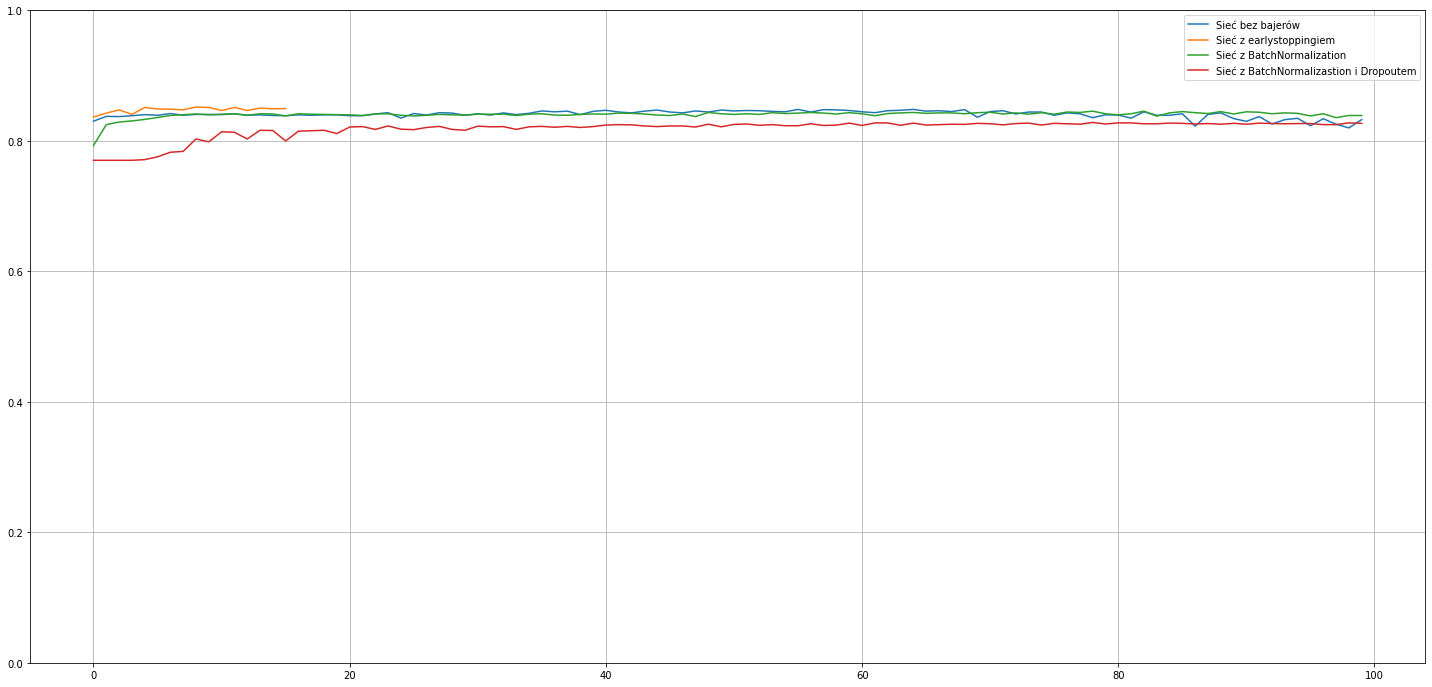

In [105]:
plt.plot(pd.DataFrame(history1.history['val_accuracy']), label='Sieć bez bajerów')
plt.plot(pd.DataFrame(history2.history['val_accuracy']), label='Sieć z earlystoppingiem')
plt.plot(pd.DataFrame(history3.history['val_accuracy']), label='Sieć z BatchNormalization')
plt.plot(pd.DataFrame(history4.history['val_accuracy']), label='Sieć z BatchNormalizastion i Dropoutem')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.rcParams["figure.figsize"] = (25,12)
plt.show()

